In [5]:
import copy
from enum import Enum
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from typing import List

from mimt import *

mi.set_variant("cuda_ad_rgb")

class Setting(Enum):
    Direct = 1
    VaryingBRDF = 2
    IndirectIllumination = 3

def create_scene(setting: Setting, integrator: str):
    texture = create_gradient_image(32, 32, color_1=[1, 0, 0], color_2=[0, 1, 0])
    texture[:, :, 2] = 0.05

    scene_dict = {
        "type": "scene",

        "integrator": {
            "type": integrator,
            "max_depth": 2,
            "hide_emitters": False,
        },

        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f().look_at(
                origin = [0, 0,  0],
                target = [0, 0, -1],
                up=[0, 1, 0]
            ),
            "film": {
                "type": "hdrfilm",
                "rfilter": { "type": "gaussian" },
                "width": 128,
                "height": 128,
                "sample_border": True
            },
            "sampler": { "type": "independent", "sample_count": 128, },
        },

        "surface_1": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f().look_at(
                origin = [0,  0, -1],
                target = [0, -1,  0],
                up=[0, 1, 0]
            ).scale(0.75),
        },

        "surface_2": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f().look_at(
                origin = [0, -2, -1],
                target = [0, 0,  -1],
                up=[0, 0, 1]
            ).scale(1),
            "emitter": { 
                "type": "area",
                "radiance": {
                    'type': 'bitmap',
                    'data': 2*texture,
                    'raw': True
                },
            }
        },
    }

    if setting == Setting.Direct:
        # Make the first surface an emitter and remove the second surface
        scene_dict["surface_1"]["emitter"] = scene_dict["surface_2"]["emitter"]
        del scene_dict["surface_2"]
    elif setting == Setting.VaryingBRDF:
        scene_dict["surface_1"]["bsdf"] = {
            "type": "diffuse",
            'reflectance': {
                'type': 'bitmap',
                'data': texture,
                'raw': True
            }
        }
        scene_dict["surface_2"]["emitter"]["radiance"] = {
            'type': 'rgb',
            'value': 10.0,
        }

    return scene_dict
    # scene_dict_overview = scene_dict.copy()
    # scene_dict_overview["sensor"] = scene_dict["sensor"].copy()
    # scene_dict_overview["sensor"]["to_world"] = mi.ScalarTransform4f.look_at(
    #     origin=[4, 4, 4], target=[0, 0, 0], up=[0, 1, 0]
    # )

def apply_transform(params: mi.SceneParameters, original: mi.Transform4f, offset: float):
    params['surface_1.to_world'] = mi.Transform4f().translate([0, 0, -offset]) @ original
    #params['surface_1.to_world'] = mi.Transform4f().rotate([0, 0, 1], offset) @ original
    #params['surface_1.to_world'] = mi.Transform4f().scale(4*offset) @ original
    params.update()
    return params

def compute_gradient_finite_differences(func: callable, x: float, h: float = 0.01):
    return (func(x + h) - func(x - h)) / (2*h)

def compute_gradient_forward(func: callable, x: float):
    x_attached = mi.Float(x)
    dr.enable_grad(x_attached)

    output = func(x_attached)

    dr.set_grad(x_attached, 1)
    dr.forward_from(x_attached)
    return dr.grad(output)

In [6]:
from mitsuba.python.ad.integrators.common import ADIntegrator

def render(scene: mi.Scene, params: mi.SceneParameters, use_point_sampling: bool, sample_emitter: bool):
    sensor: mi.Sensor = scene.sensors()[0]
    film: mi.Film     = sensor.film()

    sampler, spp = scene.integrator().prepare(sensor)

    scene.sample_emitter(sampler.next_1d(), True)

    if mi.MI_VERSION == '3.4.1':
        ray, weight, pos, det =  scene.integrator().sample_rays(scene, sensor, sampler)
    else:
        ray, weight, pos = scene.integrator().sample_rays(scene, sensor, sampler)

    if use_point_sampling and sample_emitter:
        ps    = scene.shapes()[0].sample_position(0, sampler.next_2d())
        ray.d = dr.normalize(ps.p - ray.o)

    active = mi.Bool(True)

    ray_flags = mi.RayFlags.All
    if use_point_sampling:
        ray_flags = ray_flags | mi.RayFlags.FollowShape

    si = scene.ray_intersect(ray, 
                             ray_flags=ray_flags,
                             coherent=True,
                             active=active)
    active = si.is_valid()

    emitter = si.emitter(scene)
    Le = emitter.eval(si, active)

    L = Le

    w = 1
    if use_point_sampling:
        print("point sampling...")
        dp = si.p - ray.o
        d2p_det = dr.abs(dr.dot(si.n, -dr.normalize(dp))) / dr.squared_norm(dp)
        p2u_det = dr.norm(dr.cross(si.dp_du, si.dp_dv))

        d2u_det = d2p_det #* p2u_det # <- this is required
        if mi.MI_VERSION == '3.6.0':
            inv_d2u_det = dr.select(d2u_det != 0, dr.rcp(d2u_det), 0)
        else:
            inv_d2u_det = dr.select(dr.neq(d2u_det, 0), dr.rcp(d2u_det), 0)

        if sample_emitter:
            d2u_det = dr.replace_grad(1, d2u_det) # <- this is wrong for the forward pass
            L = Le * d2u_det # / dr.detach(ps.pdf) # <- this is not required
            w = d2u_det # / dr.detach(ps.pdf)      # <- this is not required
        else:
            L = Le * dr.replace_grad(1, d2u_det * dr.detach(inv_d2u_det))
            w = dr.replace_grad(1, d2u_det * dr.detach(inv_d2u_det)) #/ dr.detach(ps.pdf)

    # Without this line, kernel compilation fails
    dr.eval(L)
    dr.eval(w)

    if use_point_sampling:
        pos = dr.select(active, sensor.sample_direction(si, [0, 0], active=active)[0].uv, pos)

    #with dr.suspend_grad():
    block = film.create_block()
    ADIntegrator._splat_to_block(
        block, film, pos,
        value=L * weight,
        weight=w,
        alpha=dr.select(active, mi.Float(1), mi.Float(0)),
        aovs=[],
        wavelengths=ray.wavelengths
    )
    
    film.put_block(block)
    img = film.develop()

    dr.eval(img)
    return img

point sampling...
point sampling...
point sampling...
point sampling...
derivative (fd) min/max:  -0.4538417 0.8494675
derivative (ad) min/max:  -0.48096877 0.91438985
2.0492976


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.351119..1.3223343].


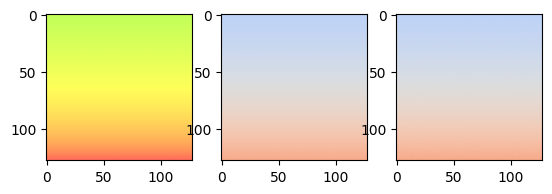

In [11]:
dr.set_flag(dr.JitFlag.Debug, True)

scene = mi.load_dict(create_scene(Setting.Direct, "prb"))

params   = mi.traverse(scene)
original = mi.Transform4f(params['surface_1.to_world'])

x = 0
render_with_offset = lambda x: render(scene, params=apply_transform(params, original, x), use_point_sampling=True, sample_emitter=False)
with dr.suspend_grad():
    img = render_with_offset(x)
img_grad_fd = compute_gradient_finite_differences(render_with_offset, x, h=0.01)
img_grad_fw = compute_gradient_forward(render_with_offset, x)

img_np  = img.numpy()
img_grad_fd_np = img_grad_fd.numpy()
img_grad_fw_np = img_grad_fw.numpy()

channel_idx = 0
print("derivative (fd) min/max: ", img_grad_fd_np[:, :, channel_idx].min(), img_grad_fd_np[:, :, channel_idx].max())
print("derivative (ad) min/max: ", img_grad_fw_np[:, :, channel_idx].min(), img_grad_fw_np[:, :, channel_idx].max())

# r = np.quantile(np.abs(img_grad_fd_np[:, :, channel_idx]), 0.99)
r = 2.0492976
print(r)
fig, axs = plt.subplots(1, 3)
axs[0].imshow(np.power(img_np, 1/2.2))
axs[1].imshow(img_grad_fd_np[:, :, channel_idx], cmap='coolwarm', vmin=-r, vmax=r)
axs[2].imshow(img_grad_fw_np[:, :, channel_idx], cmap='coolwarm', vmin=-r, vmax=r)

point sampling...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.35111877..1.3225037].


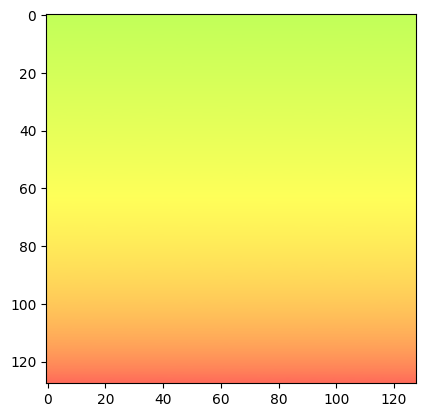

In [8]:
use_point_sampling = True

scene = mi.load_dict(create_scene(Setting.Direct, "prb"))

sensor: mi.Sensor = scene.sensors()[0]
film: mi.Film     = sensor.film()

sampler, spp = scene.integrator().prepare(sensor)

scene.sample_emitter(sampler.next_1d(), True)

if mi.MI_VERSION == '3.4.1':
    ray, weight, pos, det =  scene.integrator().sample_rays(scene, sensor, sampler)
else:
    ray, weight, pos = scene.integrator().sample_rays(scene, sensor, sampler)

if use_point_sampling:
    ps    = scene.shapes()[0].sample_position(0, sampler.next_2d())
    ray.d = dr.normalize(ps.p - ray.o)

active = mi.Bool(True)

ray_flags = mi.RayFlags.All
if use_point_sampling:
    ray_flags = ray_flags | mi.RayFlags.FollowShape

si = scene.ray_intersect(ray, 
                        ray_flags=ray_flags,
                        coherent=True,
                        active=active)
emitter = si.emitter(scene)
Le = emitter.eval(si, active)

L = Le

if use_point_sampling:
    print("point sampling...")
    dp = si.p - ray.o
    d2p_det = dr.abs(dr.dot(si.n, -dr.normalize(dp))) / dr.squared_norm(dp)
    p2u_det = dr.norm(dr.cross(si.dp_du, si.dp_dv))

    d2u_det = d2p_det * p2u_det
    if mi.MI_VERSION == '3.6.0':
        inv_d2u_det = dr.select(d2u_det != 0, dr.rcp(d2u_det), 0)
    else:
        inv_d2u_det = dr.select(dr.neq(d2u_det, 0), dr.rcp(d2u_det), 0)

    # TODO: What is the pdf of camera rays?
    # TODO: Why is this causing a crash all the time?
    #L = Le * dr.replace_grad(1, d2u_det * dr.detach(inv_d2u_det))
    L = Le * d2u_det / dr.detach(ps.pdf)
    w = d2u_det / dr.detach(ps.pdf)

# Without this line, kernel compilation fails
dr.eval(L)
dr.eval(w)

active = si.is_valid()
if use_point_sampling:
    pos = dr.select(active, sensor.sample_direction(si, [0, 0], active=active)[0].uv, pos)

#with dr.suspend_grad():
block = film.create_block()
ADIntegrator._splat_to_block(
    block, film, pos,
    value=L * weight,
    weight=w,
    alpha=dr.select(active, mi.Float(1), mi.Float(0)),
    aovs=[],
    wavelengths=ray.wavelengths
)

film.put_block(block)
if use_point_sampling:
    img = film.develop()
    plt.imshow(np.power(img[:, :], 1/2.2))
else:
    img = film.develop()
    plt.imshow(np.power(img[:, :], 1/2.2))

1.7724538509055159
1.775669134743502
1.783563169776789
1.8221461433330535


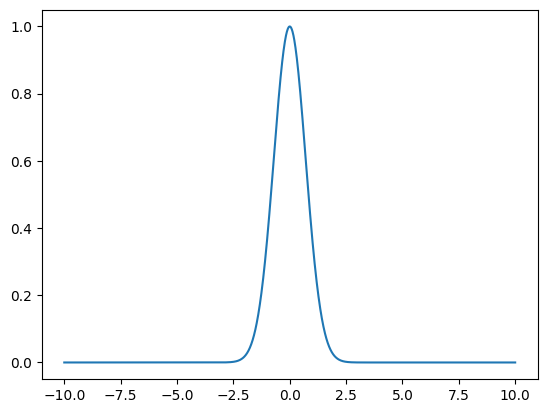

In [9]:
import math

def f(x: np.array):
    return np.exp(-x**2)

def F(x: float):
    return 0.5 * math.sqrt(np.pi) * math.erf(x)

def monte_carlo(f: callable, a: float, b: float, N: int):
    xi = (b - a) * np.random.rand(N) + a
    return np.sum(f(xi)) * (b-a) / N

N = 100
print(F(100) - F(-100))
print(monte_carlo(f, -2.5, 2.5, N))
print(monte_carlo(f,   -5,   5, N))
print(monte_carlo(f,   -100,   100, N))

x = np.linspace(-10, 10, 2000)
plt.plot(x, f(x))